In [ ]:
# Install & import library
# !pip install -q sentence-transformers scikit-learn pandas


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/NLP/dataset_matchmaking.csv'
df = pd.read_csv(file_path)

df.head()

,id_kandidat,cv_text,id_lowongan,job_desc,label
0,C0001,"Saya lulusan Statistika, pengalaman 2 tahun se...",L001,Dicari Software Engineer dengan keahlian React...,0
1,C0002,"Lulusan Akuntansi dengan pengalaman 3 tahun, t...",L002,Dibutuhkan Digital Marketer dengan fokus pada ...,0
2,C0003,"Lulusan Akuntansi dengan pengalaman 4 tahun, t...",L003,"Staff Administrasi dibutuhkan, harus menguasai...",0
3,C0004,Pengalaman 3 tahun sebagai admin dengan kemamp...,L004,"Staff Administrasi dibutuhkan, harus menguasai...",1
4,C0005,Pengalaman 1 tahun sebagai admin dengan kemamp...,L005,"Lowongan Data Analyst dengan keahlian Tableau,...",0


In [ ]:
# Load model pre-trained
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L3-v2')

# Embedding teks
cv_embeddings = model.encode(df['cv_text'].tolist(), convert_to_tensor=True)
job_embeddings = model.encode(df['job_desc'].tolist(), convert_to_tensor=True)

# Hitung cosine similarity
similarity_scores = util.cos_sim(cv_embeddings, job_embeddings).diagonal()
df['similarity'] = similarity_scores.cpu().numpy()

# Threshold sederhana
df['predicted'] = df['similarity'] > 0.5  # threshold bisa kamu sesuaikan


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# Gabungkan semua CV dan semua Job Desc sebagai dua grup teks
vectorizer = TfidfVectorizer()

# Fit dan transform ke dua grup (cv dan job)
cv_tfidf = vectorizer.fit_transform(df['cv_text'])
job_tfidf = vectorizer.transform(df['job_desc'])  # harus transform, bukan fit_transform

# Hitung cosine similarity antar pasangan kandidat dan lowongan satu per satu (baris ke baris)
tfidf_scores = np.array([
    cosine_similarity(cv_tfidf[i], job_tfidf[i])[0][0]
    for i in range(len(df))
])

# Tambahkan ke DataFrame
df['tfidf_similarity'] = tfidf_scores
df['tfidf_predicted'] = df['tfidf_similarity'] > 0.3  # threshold bisa disesuaikan


In [ ]:
# Asumsi label 1 = cocok, 0 = tidak cocok
y_true = df['label']
y_pred_bert = df['predicted']
y_pred_tfidf = df['tfidf_predicted']

print("📌 Sentence-BERT")
print("Precision:", precision_score(y_true, y_pred_bert))
print("Recall:", recall_score(y_true, y_pred_bert))
print("F1 Score:", f1_score(y_true, y_pred_bert))

print("\n📌 TF-IDF")
print("Precision:", precision_score(y_true, y_pred_tfidf))
print("Recall:", recall_score(y_true, y_pred_tfidf))
print("F1 Score:", f1_score(y_true, y_pred_tfidf))


📌 Sentence-BERT
Precision: 0.4227330779054917
Recall: 0.8348045397225725
F1 Score: 0.5612547689699025

📌 TF-IDF
Precision: 0.9766009852216748
Recall: 1.0
F1 Score: 0.9881619937694704


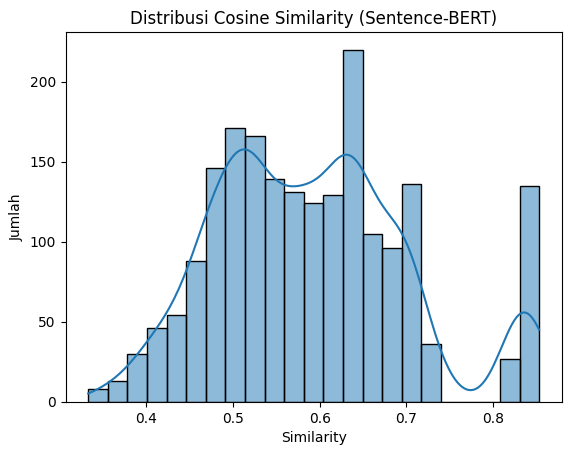

✅ File berhasil disimpan di: /content/drive/My Drive/NLP/hasil_matchmaking.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['similarity'], kde=True)
plt.title("Distribusi Cosine Similarity (Sentence-BERT)")
plt.xlabel("Similarity")
plt.ylabel("Jumlah")
plt.show()

# Simpan hasil
output_path = '/content/drive/My Drive/NLP/hasil_matchmaking.csv'
df.to_csv(output_path, index=False)

print("✅ File berhasil disimpan di:", output_path)


In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, models
from torch.utils.data import DataLoader
import pandas as pd
import torch

In [ ]:
# Ganti path sesuai lokasi kamu menyimpan file hasil labeling di Drive
file_path = "/content/drive/My Drive/NLP/hasil_matchmaking.csv"
df = pd.read_csv(file_path)
df.head()


,id_kandidat,cv_text,id_lowongan,job_desc,label,similarity,predicted,tfidf_similarity,tfidf_predicted
0,C0001,"Saya lulusan Statistika, pengalaman 2 tahun se...",L001,Dicari Software Engineer dengan keahlian React...,0,0.559876,True,0.043790,False
1,C0002,"Lulusan Akuntansi dengan pengalaman 3 tahun, t...",L002,Dibutuhkan Digital Marketer dengan fokus pada ...,0,0.620396,True,0.113429,False
2,C0003,"Lulusan Akuntansi dengan pengalaman 4 tahun, t...",L003,"Staff Administrasi dibutuhkan, harus menguasai...",0,0.399358,False,0.038240,False
3,C0004,Pengalaman 3 tahun sebagai admin dengan kemamp...,L004,"Staff Administrasi dibutuhkan, harus menguasai...",1,0.579166,True,0.752086,True
4,C0005,Pengalaman 1 tahun sebagai admin dengan kemamp...,L005,"Lowongan Data Analyst dengan keahlian Tableau,...",0,0.611146,True,0.096989,False


In [ ]:
# SIAPKAN DATA UNTUK FINE TUNING
# Buat InputExample
train_examples = [
    InputExample(texts=[row['cv_text'], row['job_desc']], label=float(row['label']))
    for _, row in df.iterrows()
]


In [ ]:
# Bagi Data Train dan Validation
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_examples, test_size=0.1, random_state=42)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=16)

In [ ]:
# Load Pretrained Model dan Setup Loss Function

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L3-v2')

train_loss = losses.CosineSimilarityLoss(model=model)


In [ ]:
# Fine-tuning

num_epochs = 1  # untuk uji coba cepat, nanti bisa dinaikkan

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=100,
    show_progress_bar=True
)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: putera-harri (putera-harri-universitas-al-azhar-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss


In [ ]:
# Simpan Model ke Google Drive

save_path = "/content/drive/My Drive/NLP/sentencebert-finetuned"
model.save(save_path)
print(f"✅ Model disimpan di: {save_path}")


✅ Model disimpan di: /content/drive/My Drive/NLP/sentencebert-finetuned


In [ ]:
# Menggunakan Model Hasil Fine-Tune

import torch
# Load kembali model yang sudah ditraining
model_ft = SentenceTransformer(save_path)

# 5. Encode teks kandidat dan lowongan
cv_embeddings = model_ft.encode(df['cv_text'].tolist(), convert_to_tensor=True)
job_embeddings = model_ft.encode(df['job_desc'].tolist(), convert_to_tensor=True)



In [ ]:
# Hitung cosine similarity
cos_sim_ft = torch.nn.functional.cosine_similarity(cv_embeddings, job_embeddings)

# Tambahkan kolom similarity ke DataFrame
df['similarity_ft'] = cos_sim_ft.cpu().numpy()

# Prediksi binary berdasarkan threshold similarity
df['predicted_ft'] = df['similarity_ft'] > 0.5  # kamu bisa adjust threshold ini



In [ ]:
# Evaluasi Model Fine-Tuned
print("Evaluasi Model Fine-Tuned Sentence-BERT:")
print("Precision :", precision_score(df['label'], df['predicted_ft']))
print("Recall    :", recall_score(df['label'], df['predicted_ft']))
print("F1 Score  :", f1_score(df['label'], df['predicted_ft']))

# (Opsional) Simpan hasil ke CSV baru di Google Drive
output_path = "/content/drive/My Drive/NLP/hasil_matchmaking_finetuned.csv"
df.to_csv(output_path, index=False)
print(f"✅ Hasil evaluasi disimpan ke: {output_path}")



Evaluasi Model Fine-Tuned Sentence-BERT:
Precision : 0.9974842767295597
Recall    : 1.0
F1 Score  : 0.9987405541561712
✅ Hasil evaluasi disimpan ke: /content/drive/My Drive/NLP/hasil_matchmaking_finetuned.csv


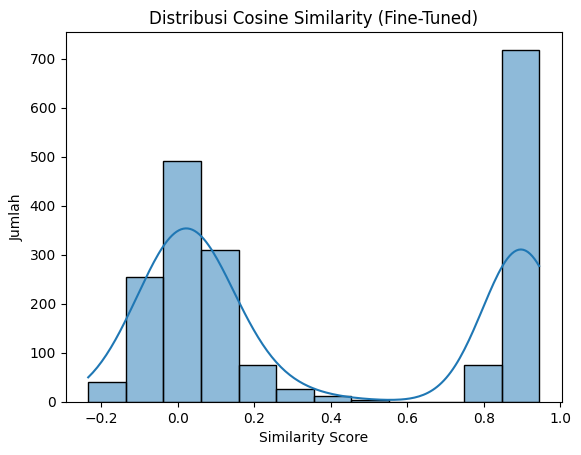

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['similarity_ft'], kde=True)
plt.title("Distribusi Cosine Similarity (Fine-Tuned)")
plt.xlabel("Similarity Score")
plt.ylabel("Jumlah")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Evaluasi Model Pre-trained (Sebelum Fine-Tune):
Precision : 0.4227330779054917
Recall    : 0.8348045397225725
F1 Score  : 0.5612547689699025


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Evaluasi Model Fine-Tuned:
Precision : 0.9974842767295597
Recall    : 1.0
F1 Score  : 0.9987405541561712


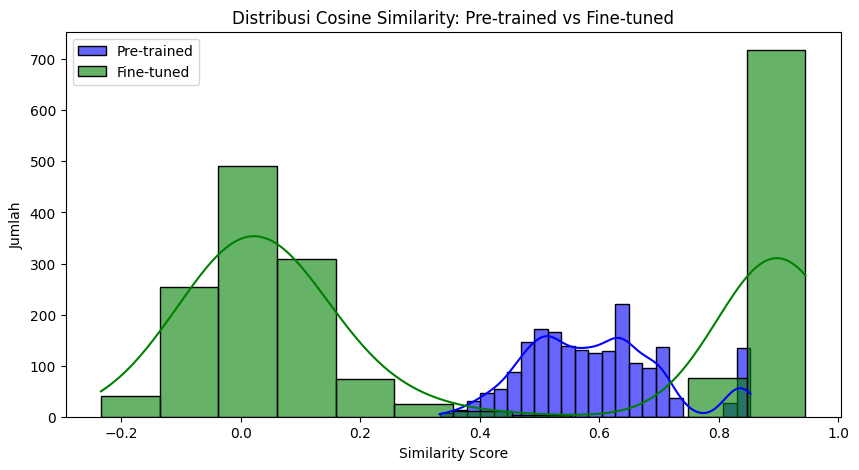

In [ ]:
# Perbandingan Sebelum vs Sesudah Fine-Tuning

import pandas as pd
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from google.colab import drive
drive.mount('/content/drive')

# Load hasil matchmaking awal (pre-finetune)
df = pd.read_csv("/content/drive/My Drive/NLP/hasil_matchmaking.csv")

# Threshold prediksi awal
df['predicted_pre'] = df['similarity'] > 0.5

print("\n Evaluasi Model Pre-trained (Sebelum Fine-Tune):")
print("Precision :", precision_score(df['label'], df['predicted_pre']))
print("Recall    :", recall_score(df['label'], df['predicted_pre']))
print("F1 Score  :", f1_score(df['label'], df['predicted_pre']))

# Load model fine-tuned
model_ft = SentenceTransformer("/content/drive/My Drive/NLP/sentencebert-finetuned")

# Encode ulang
cv_embeddings = model_ft.encode(df['cv_text'].tolist(), convert_to_tensor=True)
job_embeddings = model_ft.encode(df['job_desc'].tolist(), convert_to_tensor=True)

# Cosine similarity baru
df['similarity_ft'] = torch.nn.functional.cosine_similarity(cv_embeddings, job_embeddings).cpu().numpy()
df['predicted_ft'] = df['similarity_ft'] > 0.5

print("\n Evaluasi Model Fine-Tuned:")
print("Precision :", precision_score(df['label'], df['predicted_ft']))
print("Recall    :", recall_score(df['label'], df['predicted_ft']))
print("F1 Score  :", f1_score(df['label'], df['predicted_ft']))

plt.figure(figsize=(10, 5))
sns.histplot(df['similarity'], label="Pre-trained", kde=True, color='blue', alpha=0.6)
sns.histplot(df['similarity_ft'], label="Fine-tuned", kde=True, color='green', alpha=0.6)
plt.title("Distribusi Cosine Similarity: Pre-trained vs Fine-tuned")
plt.xlabel("Similarity Score")
plt.ylabel("Jumlah")
plt.legend()
plt.show()

df.to_csv("/content/drive/My Drive/NLP/perbandingan_pre_vs_finetuned.csv", index=False)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Perbandingan Kinerja Model
Metrik       | Pre-trained  | Fine-tuned  
----------------------------------------
Precision    | 0.4227       | 0.9975      
Recall       | 0.8348       | 1.0000      
F1 Score     | 0.5613       | 0.9987      


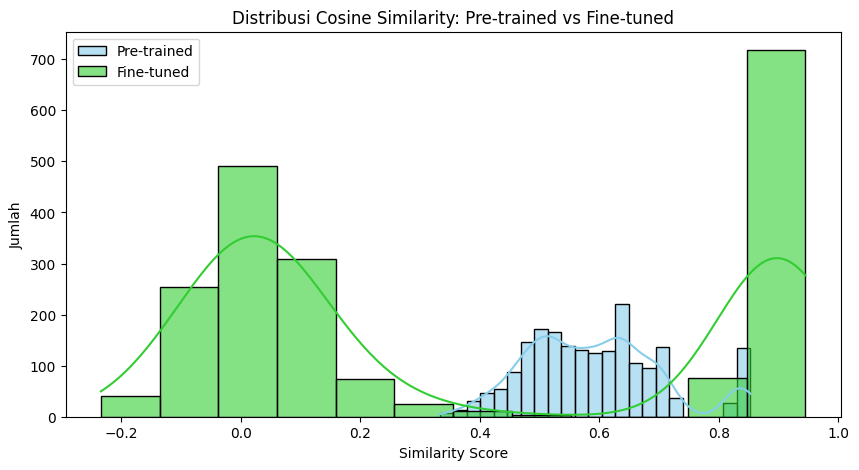

In [ ]:
# Evaluasi dan perbandingan

df = pd.read_csv("/content/drive/My Drive/NLP/hasil_matchmaking.csv")

# Evaluasi Pre-trained Model
df['predicted_pre'] = df['similarity'] > 0.5

precision_pre = precision_score(df['label'], df['predicted_pre'])
recall_pre = recall_score(df['label'], df['predicted_pre'])
f1_pre = f1_score(df['label'], df['predicted_pre'])

# Evaluasi Fine-Tuned Model
model_ft = SentenceTransformer("/content/drive/My Drive/NLP/sentencebert-finetuned")

cv_embeddings = model_ft.encode(df['cv_text'].tolist(), convert_to_tensor=True)
job_embeddings = model_ft.encode(df['job_desc'].tolist(), convert_to_tensor=True)

similarity_ft = torch.nn.functional.cosine_similarity(cv_embeddings, job_embeddings).cpu().numpy()
df['similarity_ft'] = similarity_ft
df['predicted_ft'] = df['similarity_ft'] > 0.5

precision_ft = precision_score(df['label'], df['predicted_ft'])
recall_ft = recall_score(df['label'], df['predicted_ft'])
f1_ft = f1_score(df['label'], df['predicted_ft'])

# Tampilkan Tabel Perbandingan
print("Perbandingan Kinerja Model")

print(f"{'Metrik':<12} | {'Pre-trained':<12} | {'Fine-tuned':<12}")
print(f"{'-'*40}")
print(f"{'Precision':<12} | {precision_pre:<12.4f} | {precision_ft:<12.4f}")
print(f"{'Recall':<12} | {recall_pre:<12.4f} | {recall_ft:<12.4f}")
print(f"{'F1 Score':<12} | {f1_pre:<12.4f} | {f1_ft:<12.4f}")

# (Opsional) Visualisasi Distribusi Cosine Similarity
plt.figure(figsize=(10, 5))
sns.histplot(df['similarity'], label="Pre-trained", kde=True, color='skyblue', alpha=0.6)
sns.histplot(df['similarity_ft'], label="Fine-tuned", kde=True, color='limegreen', alpha=0.6)
plt.title("Distribusi Cosine Similarity: Pre-trained vs Fine-tuned")
plt.xlabel("Similarity Score")
plt.ylabel("Jumlah")
plt.legend()
plt.show()



In [ ]:
# Top-3 rekomendasi per Kandidat
# Untuk memberikan rekomendasi

model_ft = SentenceTransformer("/content/drive/My Drive/NLP/sentencebert-finetuned")

# Asumsi kamu pakai dataset asli sebelum dibentuk pasangan
# Diambil dari hasil_matchmaking.csv

df_full = pd.read_csv("/content/drive/My Drive/NLP/hasil_matchmaking.csv")

# Ambil data unik kandidat dan lowongan
df_kandidat = df_full[['id_kandidat', 'cv_text']].drop_duplicates().reset_index(drop=True)
df_lowongan = df_full[['id_lowongan', 'job_desc']].drop_duplicates().reset_index(drop=True)

kandidat_embeddings = model_ft.encode(df_kandidat['cv_text'].tolist(), convert_to_tensor=True)
lowongan_embeddings = model_ft.encode(df_lowongan['job_desc'].tolist(), convert_to_tensor=True)

# Matriks cosine similarity (size: [jumlah_kandidat x jumlah_lowongan])
cos_sim_matrix = util.cos_sim(kandidat_embeddings, lowongan_embeddings)  # tensor

top_n = 3
top_results = []

for i, kandidat_id in enumerate(df_kandidat['id_kandidat']):
    top_scores, top_indices = torch.topk(cos_sim_matrix[i], k=top_n)

    for score, idx in zip(top_scores, top_indices): idx = idx.item()  # konversi dari tensor ke int
    result = {
        'id_kandidat': kandidat_id,
        'id_lowongan': df_lowongan.iloc[idx]['id_lowongan'],
        'cv_text': df_kandidat.iloc[i]['cv_text'],
        'job_desc': df_lowongan.iloc[idx]['job_desc'],
        'similarity_score': score.item()
    }
    top_results.append(result)


output_path = "/content/drive/My Drive/NLP/top3_rekomendasi_per_kandidat.csv"
df_topn = pd.DataFrame(top_results)
df_topn.to_csv(output_path, index=False)

print(f"File rekomendasi disimpan di: {output_path}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


File rekomendasi disimpan di: /content/drive/My Drive/NLP/top3_rekomendasi_per_kandidat.csv


In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

# Gabungkan kembali untuk mendapatkan label
df_merged = pd.merge(df_topn, df_full[['id_kandidat', 'id_lowongan', 'label']],
                     on=['id_kandidat', 'id_lowongan'], how='left')

# Bentuk relevancy matrix: list of label-list per kandidat
relevancy_matrix = []
for kandidat_id in df_kandidat['id_kandidat']:
    top3 = df_merged[df_merged['id_kandidat'] == kandidat_id]
    relevancies = top3['label'].fillna(0).astype(int).tolist()
    relevancy_matrix.append(relevancies)

def mean_reciprocal_rank(relevancy_matrix):
    total = 0
    for rels in relevancy_matrix:
        for rank, rel in enumerate(rels, start=1):
            if rel == 1:
                total += 1 / rank
                break
    return total / len(relevancy_matrix)

mrr_score = mean_reciprocal_rank(relevancy_matrix)
print(f"📊 Mean Reciprocal Rank (MRR): {mrr_score:.4f}")

📊 Mean Reciprocal Rank (MRR): 0.0600


In [ ]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load dataset
df_full = pd.read_csv("/content/drive/My Drive/NLP/hasil_matchmaking.csv")

# Kandidat dan lowongan unik
df_kandidat = df_full[['id_kandidat', 'cv_text']].drop_duplicates().reset_index(drop=True)
df_lowongan = df_full[['id_lowongan', 'job_desc']].drop_duplicates().reset_index(drop=True)

def mean_reciprocal_rank(relevancy_matrix):
    total = 0
    for rels in relevancy_matrix:
        for rank, rel in enumerate(rels, start=1):
            if rel == 1:
                total += 1 / rank
                break
    return total / len(relevancy_matrix)

def evaluate_model(model, model_type, threshold=0.5, top_n=3):
    # Hitung embedding dan similarity matrix
    if model_type == "tfidf":
        combined = df_kandidat['cv_text'].tolist() + df_lowongan['job_desc'].tolist()
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(combined)
        cv_vecs = tfidf_matrix[:len(df_kandidat)]
        job_vecs = tfidf_matrix[len(df_kandidat):]
        sim_matrix = cosine_similarity(cv_vecs, job_vecs)
    else:
        cv_vecs = model.encode(df_kandidat['cv_text'].tolist(), convert_to_tensor=True)
        job_vecs = model.encode(df_lowongan['job_desc'].tolist(), convert_to_tensor=True)
        sim_matrix = util.cos_sim(cv_vecs, job_vecs).cpu().numpy()

    predictions = []
    relevancy_matrix = []

    for i, kandidat_id in enumerate(df_kandidat['id_kandidat']):
        sims = sim_matrix[i]
        for j, job_id in enumerate(df_lowongan['id_lowongan']):
            score = sims[j]
            pred_label = 1 if score > threshold else 0

            true_label_row = df_full[
                (df_full['id_kandidat'] == kandidat_id) &
                (df_full['id_lowongan'] == job_id)
            ]
            true_label = true_label_row['label'].values[0] if not true_label_row.empty else 0

            predictions.append((true_label, pred_label, score, kandidat_id, job_id))

        # Untuk MRR: ambil top-N
        sorted_indices = np.argsort(sims)[::-1][:top_n]
        relevancies = []
        for idx in sorted_indices:
            job_id = df_lowongan.iloc[idx]['id_lowongan']
            rel_row = df_full[
                (df_full['id_kandidat'] == kandidat_id) &
                (df_full['id_lowongan'] == job_id)
            ]
            rel = rel_row['label'].values[0] if not rel_row.empty else 0
            relevancies.append(rel)
        relevancy_matrix.append(relevancies)

    # Pisahkan label
    y_true = [x[0] for x in predictions]
    y_pred = [x[1] for x in predictions]

    # Hitung metrik
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    mrr       = mean_reciprocal_rank(relevancy_matrix)

    return precision, recall, f1, mrr

# Model pre-trained
model_pretrained = SentenceTransformer('paraphrase-MiniLM-L3-v2')
pre_precision, pre_recall, pre_f1, pre_mrr = evaluate_model(model_pretrained, "sbert-pretrained")

# Model fine-tuned
model_ft = SentenceTransformer("/content/drive/My Drive/NLP/sentencebert-finetuned")
ft_precision, ft_recall, ft_f1, ft_mrr = evaluate_model(model_ft, "sbert-finetuned")

# Tampilkan hasil perbandingan
print("📊 Perbandingan Kinerja Model")
print("| Metrik     | Pre-trained  | Fine-tuned  |")
print("|------------|--------------|-------------|")
print(f"| Precision  | {pre_precision:.4f}      | {ft_precision:.4f}     |")
print(f"| Recall     | {pre_recall:.4f}      | {ft_recall:.4f}     |")
print(f"| F1 Score   | {pre_f1:.4f}      | {ft_f1:.4f}     |")
print(f"| MRR        | {pre_mrr:.4f}      | {ft_mrr:.4f}     |")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 Perbandingan Kinerja Model
| Metrik     | Pre-trained  | Fine-tuned  |
|------------|--------------|-------------|
| Precision  | 0.0398      | 0.0400     |
| Recall     | 0.7235      | 0.1216     |
| F1 Score   | 0.0754      | 0.0602     |
| MRR        | 0.0797      | 0.1072     |
